teeth1 shape: (178337, 3)
teeth2 shape: (195369, 3)


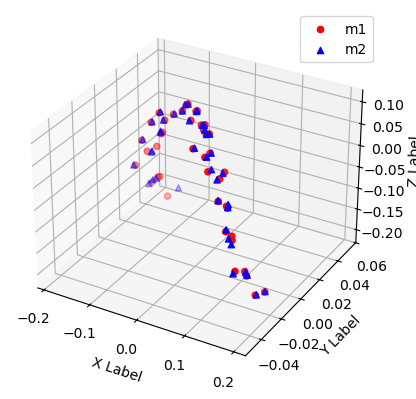

Rotation matrixes (R1,R2):
 [[ 1.00000000e+00  1.03572852e-16 -3.39600981e-17]
 [ 7.58172767e-17  1.00000000e+00 -6.55967587e-17]
 [-8.98920793e-18 -1.96791408e-16  1.00000000e+00]] [[ 0.98938283  0.14326186  0.02444702]
 [-0.13357268  0.9626538  -0.23549098]
 [-0.05727089  0.22972528  0.97156901]]
Translation vectors (t1,t2): [-20.87863254   2.93227534 -24.92558863] [-17.81334835  -3.10111289   0.75422922]
Original teeth1 points (first 5 rows):
 [[ 4.71126652 -6.39703655  7.42307186]
 [ 4.72509861 -6.39717722  7.53156805]
 [ 4.71671152 -6.52210808  7.44245434]
 [ 4.7965765  -7.02202225  8.28253937]
 [ 4.78009033 -6.89695215  8.15713406]]
Transformed teeth1 points (first 5 rows):
 [[-16.16736602  -3.46476121 -17.50251677]
 [-16.15353393  -3.46490188 -17.39402058]
 [-16.16192102  -3.58983274 -17.48313429]
 [-16.08205604  -4.08974691 -16.64304926]
 [-16.09854221  -3.96467681 -16.76845457]]
Original MSE (before transformation): 774.577950
Transformed MSE (after alignment): 0.271899
Aligne

In [15]:
import json
import trimesh  # For loading .ply and .stl files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import procrustes
from Extract_rigid_transformation_withoutS import extract_rigid_transformation
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.nn.functional as F

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# Function to load 3D mesh from .ply or .stl
def load_mesh(file_path):
    mesh = trimesh.load(file_path)  # Load the triangular mesh
    points = np.array(mesh.vertices)  # Extract vertex coordinates (N, 3)
    return points

# Function to calculate MSE (Mean Squared Error)
def compute_mse(points1, points2):
    return np.mean(np.sum((points1 - points2) ** 2, axis=1))

# Function to load landmarks from .json
def load_landmarks_from_json(json_path):
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)  # read JSON data
    # Extract "location" from each item
    landmarks = np.array([item["location"] for item in data if "location" in item])
    return landmarks  # return (M,3) NumPy array


# Load ROI landmarks from .json files
landmarks1 = load_landmarks_from_json("landmarks/A37/lower13.json")  # Shape (M,3)
landmarks2 = load_landmarks_from_json("landmarks/A37/lower16.json")  # Shape (M,3)

# Load teeth mesh data from .csv files
#landmarks1 = pd.read_csv(r"C:\Users\Fu\download\2013.csv")
#landmarks2 = pd.read_csv(r"C:\Users\Fu\Desktop\2016.csv")
# Ensure both landmarks are represented as M×3 matrices
assert landmarks1.shape == landmarks2.shape, "The number of landmarks should be matched"

# Load teeth mesh data from .ply and .stl files
teeth1 = load_mesh("pointcloud_raw/A37/A37 lower 2013.ply")  # First teeth model

teeth2 = load_mesh("pointcloud_raw/A37/A37 lower 2016.ply")  # Second teeth model

print("teeth1 shape:", teeth1.shape)  # (N1, 3)
print("teeth2 shape:", teeth2.shape)  # (N2, 3)

# Perform Procrustes alignment on landmarks
m1, m2, disparity = procrustes(landmarks1, landmarks2)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(m1[:, 0], m1[:, 1], m1[:, 2], c='r', marker='o', label='m1')
ax.scatter(m2[:, 0], m2[:, 1], m2[:, 2], c='b', marker='^', label='m2')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.legend()

plt.show()

# Extract the rigid transformation parameters (rotation, scaling, and translation)
R1, t1 = extract_rigid_transformation(landmarks1, m1)
R2, t2 = extract_rigid_transformation(landmarks2, m2)

# Print global rigid transformation components
print("Rotation matrixes (R1,R2):\n", R1, R2)
# print("Scaling factors (s1,s2):", s1, s2)
print("Translation vectors (t1,t2):", t1, t2)


# Apply the rigid transformation to whole datasets
teeth1_transformed = teeth1 @ R1.T + t1
teeth2_transformed = teeth2 @ R2.T + t2


print("Original teeth1 points (first 5 rows):\n", teeth1[:5])
print("Transformed teeth1 points (first 5 rows):\n", teeth1_transformed[:5])

# Compute the MSE (expected to be close to 0 if properly aligned)
mse_original = compute_mse(landmarks1, landmarks2)

m1 = landmarks1 @ R1.T + t1
m2 = landmarks2 @ R2.T + t2

mse_transformed = compute_mse(m1,m2)

mesh1 = trimesh.load("pointcloud_raw/A37/A37 lower 2013.ply")
mesh2 = trimesh.load("pointcloud_raw/A37/A37 lower 2016.ply")

print(f"Original MSE (before transformation): {mse_original:.6f}")
print(f"Transformed MSE (after alignment): {mse_transformed:.6f}")


# 使用对齐后的顶点替换原始 mesh 的顶点
mesh1_aligned = trimesh.Trimesh(vertices=teeth1_transformed, faces=mesh1.faces)
mesh2_aligned = trimesh.Trimesh(vertices=teeth2_transformed, faces=mesh2.faces)

# 保存为 PLY 文件
mesh1_aligned.export("pointcloud_raw/A37/13_aligned.ply")
mesh2_aligned.export("pointcloud_raw/A37/16_aligned.ply")

print("Aligned meshes saved successfully! ")



In [16]:
# Function to calculate Chamfer distance between two point clouds using NumPy
from scipy.spatial import cKDTree

def chamfer_distance(P, Q):
    """
    Compute the Chamfer distance between two point clouds P and Q, and use KDTree to avoid the construction of large-scale distance matrix.
    Parameters:
      P: NumPy array，shape (N, D)
      Q: NumPy array，shape (M, D)
    Return:
      Scalar value of Chamfer distance 
    """
    # For each point in P, find the closest point in Q
    tree_Q = cKDTree(Q)
    dists_P, _ = tree_Q.query(P, k=1)  # Returns the shortest distance from each point in P to Q
    # For each point in Q, find the closest point in P
    tree_P = cKDTree(P)
    dists_Q, _ = tree_P.query(Q, k=1)

    # return Chamfer distance. The square of the distance is used here.
    return np.sum(dists_P ** 2) + np.sum(dists_Q ** 2)

loss_original = chamfer_distance(teeth1, teeth2)
loss_transformed = chamfer_distance(teeth1_transformed, teeth2_transformed)

print(f"Original Chamfer distance (before transformation) loss: {loss_original:.6f}")
print(f"Transformed Chamfer distance (after alignment) loss: {loss_transformed:.6f}")

Original Chamfer distance (before transformation) loss: 67776278.858512
Transformed Chamfer distance (after alignment) loss: 188626.545435


In [17]:
def compute_nn_mse(source_points, target_points):
    """
    For each point in the source, find the nearest neighbor in the target and calculate the MSE.
    """
    tree = cKDTree(target_points)
    dists, _ = tree.query(source_points)
    return np.mean(dists ** 2)

loss_original = compute_nn_mse(teeth1, teeth2)
loss_transformed = compute_nn_mse(teeth1_transformed, teeth2_transformed)

print(f"Original MSE (before transformation) loss: {loss_original:.6f}")
print(f"Transformed MSE (after alignment) loss: {loss_transformed:.6f}")

Original MSE (before transformation) loss: 190.682994
Transformed MSE (after alignment) loss: 0.361113
